In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import torch

import constant
from constant import org_cols, wsr_cols, geo_cols, semigeo_cols
import tools
import myplot
import features
from models import MLP_Regression, train_model, timeseries_kfold_validation_training
path = "PL_SC_1/"

# Load Files

In [3]:
settlement = pd.read_parquet(constant.settlement_train_path)
dtype = {"GSRN":str,"Parent_GSRN":str,"Turbine_type":str,"BBR_municipal":str,"Placement":str,"grid":str}
windmill = pd.read_csv(constant.windmill_PL_SC_path, dtype=dtype)

wu10 = pd.read_parquet(constant.wu10_path)
wv10 = pd.read_parquet(constant.wv10_path)
wu100 = pd.read_parquet(constant.wu100_path)
wv100 = pd.read_parquet(constant.wv100_path)

tmp2 = pd.read_parquet(constant.tmp2_path)
tmp100 = pd.read_parquet(constant.tmp100_path)

In [4]:
len(windmill)

28

In [5]:
df = pd.merge(windmill, settlement, on="GSRN")

# Feature Extraction

In [6]:
features.fun_register(wu10, wv10, wu100, wv100, tmp2, tmp100)

In [7]:
df = features.parallelize_extract(df)

parallelize_extract time:  1266.5295810699463


In [10]:
df,ply_models_rn,_ = features.extract_quantiles(df, "hws_uv_rn")
df,ply_models_wsr,_ = features.extract_quantiles(df, "hws_uv_wsr")

In [11]:
cols_filter = ["grid", "month", "hour", "GSRN", "Turbine_type", "Placement", "Parent_GSRN", "BBR_municipal", "TIME_CET", "predicted_ahead", 'UTM_x', 'UTM_y', 'VAERDI', 'max_VAERDI', 'In_service']

In [12]:
feat = [x for x in df.columns if x not in cols_filter]
df = tools.normalize_features(df, feat)

In [13]:
df["TIME_CET"] = pd.to_datetime(df["TIME_CET"])

In [16]:
date_s = pd.to_datetime("2019-03-01")
df_train = df[df["TIME_CET"] < date_s].sort_values(["TIME_CET", "GSRN"]).reset_index(drop=True)
df_evl = df[df["TIME_CET"] >= date_s].sort_values(["TIME_CET", "GSRN"]).reset_index(drop=True)

In [17]:
len(df_train)

244636

In [20]:
df_train.to_parquet(constant.PL_SC_TRAIN_path, index=False)
df_evl.to_parquet(constant.PL_SC_EVL_path, index=False)

# Neural Network Train

In [2]:
df_train = pd.read_parquet(constant.PL_SC_TRAIN_path)

In [11]:
target = ["VAERDI"]
n_groups=10
lr=0.001
num_epochs=50
hidden_size = 1000
output_size = 1

## Original Features


In [13]:
model_original = MLP_Regression(
  input_size=45,
  hidden_size=hidden_size
)

### Timeserise K-Fold-Validation

In [14]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=org_cols, target=target, n_groups=n_groups, model=model_original, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.03245575353503227 test loss: 0.02847539447247982
Epoch 10 train loss: 0.024551279842853546 test loss: 0.02285068668425083
Epoch 20 train loss: 0.02344609797000885 test loss: 0.022790608927607536
Epoch 30 train loss: 0.02236296981573105 test loss: 0.023396020755171776
Epoch 40 train loss: 0.021446043625473976 test loss: 0.024267850443720818
Epoch 49 train loss: 0.020556703209877014 test loss: 0.025263236835598946
Epoch 0 train loss: 0.02233901061117649 test loss: 0.008662531152367592
Epoch 10 train loss: 0.024151956662535667 test loss: 0.01211379375308752
Epoch 20 train loss: 0.022124825045466423 test loss: 0.010408477857708931
Epoch 30 train loss: 0.02092953771352768 test loss: 0.009112398140132427
Epoch 40 train loss: 0.020176537334918976 test loss: 0.008618509396910667
Epoch 49 train loss: 0.019425569102168083 test loss: 0.008465143851935863
Epoch 0 train loss: 0.018989628180861473 test loss: 0.01179449912160635
Epoch 10 train loss: 0.019103843718767166 test los

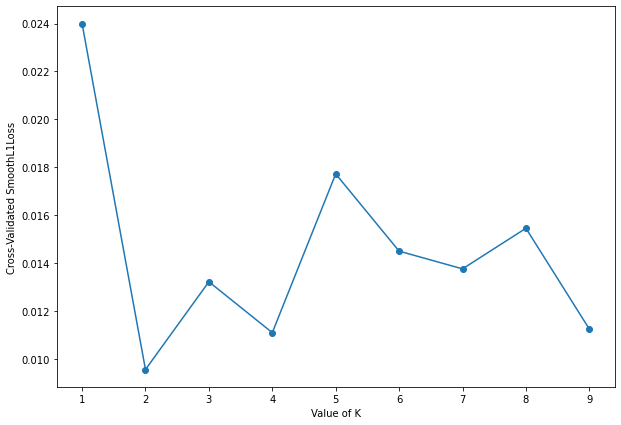

<Figure size 432x288 with 0 Axes>

In [17]:
myplot.k_fold_validation(n_groups, k_scores, save_name=path+"original_k_fold.png")

### Train model

In [18]:
x_train, y_train = df_train[org_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [19]:
model_original, train_hist_original, _ = train_model(
                                            model_original, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            save_name=path+"original_model.pth")

Epoch 0 train loss: 0.00916120782494545
Epoch 10 train loss: 0.00930306501686573
Epoch 20 train loss: 0.009104062803089619
Epoch 30 train loss: 0.009004282765090466
Epoch 40 train loss: 0.008965810760855675


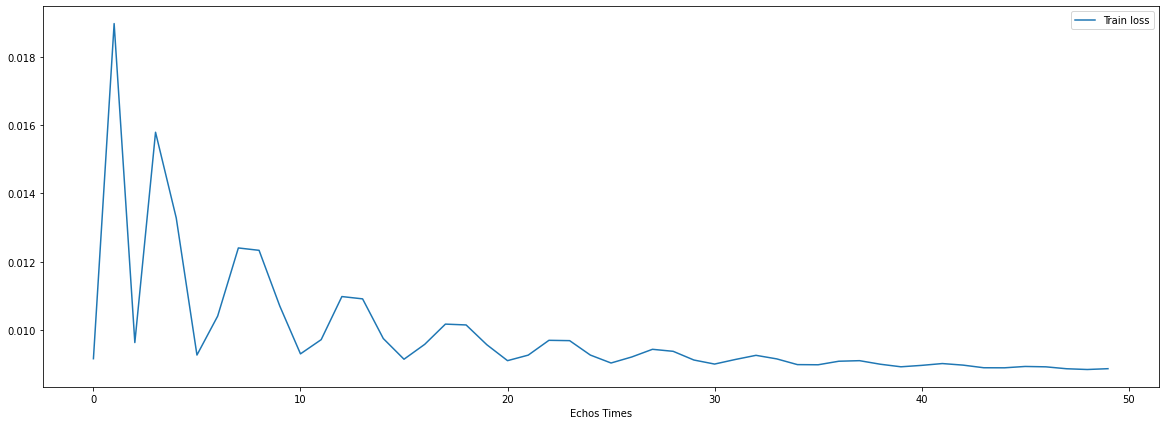

In [42]:
myplot.model_loss({"Train loss":train_hist_original}, save_name=path+"original_loss.png")

## Windshear Features

In [22]:
model_wsr = MLP_Regression(
  input_size=47,
  hidden_size=hidden_size
)

In [23]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=wsr_cols, target=target, n_groups=n_groups, model=model_wsr, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.043327901512384415 test loss: 0.03617372736334801
Epoch 10 train loss: 0.015321971848607063 test loss: 0.016846513375639915
Epoch 20 train loss: 0.012276822701096535 test loss: 0.014790636487305164
Epoch 30 train loss: 0.011716953478753567 test loss: 0.013722550123929977
Epoch 40 train loss: 0.011160659603774548 test loss: 0.013381383381783962
Epoch 49 train loss: 0.011029026471078396 test loss: 0.013380058109760284
Epoch 0 train loss: 0.011870917864143848 test loss: 0.005795512348413467
Epoch 10 train loss: 0.013084574602544308 test loss: 0.007397905923426151
Epoch 20 train loss: 0.012149474583566189 test loss: 0.006594916805624962
Epoch 30 train loss: 0.011643141508102417 test loss: 0.005972051527351141
Epoch 40 train loss: 0.011499564163386822 test loss: 0.005765753332525492
Epoch 49 train loss: 0.011410297825932503 test loss: 0.005694862920790911
Epoch 0 train loss: 0.01124888751655817 test loss: 0.007068137638270855
Epoch 10 train loss: 0.0116958599537611 tes

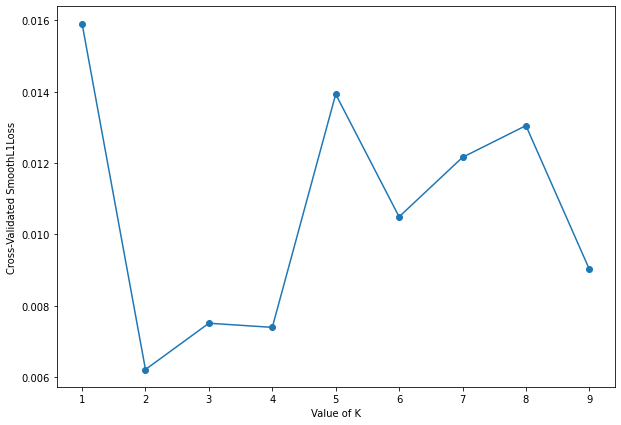

<Figure size 432x288 with 0 Axes>

In [24]:
myplot.k_fold_validation(n_groups, k_scores, save_name=path+"wsr_k_fold.png")

### Train model

In [25]:
x_train, y_train = df_train[wsr_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [26]:
model_wsr, train_hist_wsr, _ = train_model(model_wsr, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            save_name=path+"wsr_model.pth")

Epoch 0 train loss: 0.009019910357892513
Epoch 10 train loss: 0.010391010902822018
Epoch 20 train loss: 0.009309583343565464
Epoch 30 train loss: 0.00893552415072918
Epoch 40 train loss: 0.008871178142726421


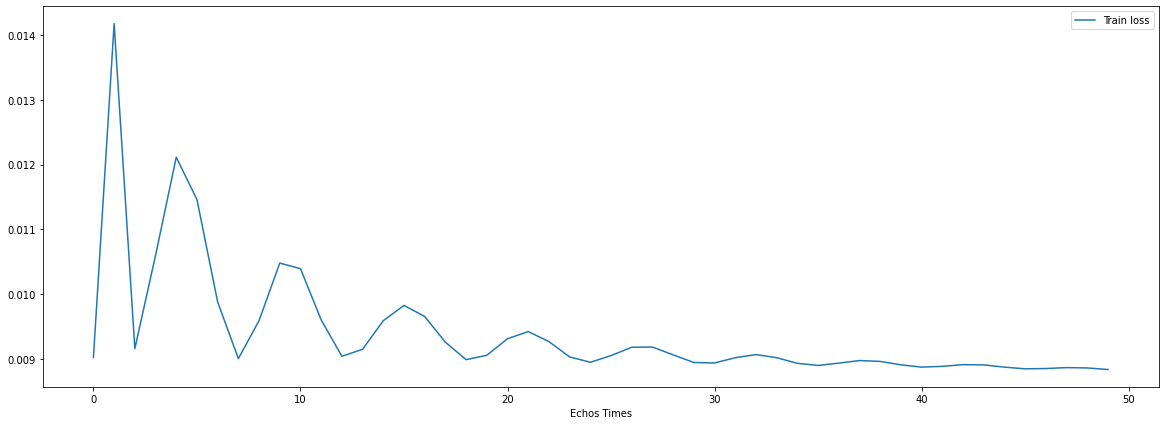

In [27]:
myplot.model_loss({"Train loss":train_hist_wsr}, save_name=path+"wsr_loss.png")

## Geo Features

In [29]:
model_geo = MLP_Regression(
  input_size=49,
  hidden_size=hidden_size
)

In [30]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=geo_cols, target=target, n_groups=n_groups, model=model_geo, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.04314175248146057 test loss: 0.03545672073960304
Epoch 10 train loss: 0.01068778708577156 test loss: 0.010719003155827522
Epoch 20 train loss: 0.00862689595669508 test loss: 0.008552229963243008
Epoch 30 train loss: 0.00804173108190298 test loss: 0.007293287664651871
Epoch 40 train loss: 0.00748104602098465 test loss: 0.00693236431106925
Epoch 49 train loss: 0.007338384166359901 test loss: 0.006902322173118591
Epoch 0 train loss: 0.007642894051969051 test loss: 0.00415461091324687
Epoch 10 train loss: 0.009212477132678032 test loss: 0.005806188099086285
Epoch 20 train loss: 0.007768153678625822 test loss: 0.004458680283278227
Epoch 30 train loss: 0.007411590311676264 test loss: 0.0041033546440303326
Epoch 40 train loss: 0.007356797810643911 test loss: 0.004035813268274069
Epoch 49 train loss: 0.007304209750145674 test loss: 0.00400167889893055
Epoch 0 train loss: 0.007118049543350935 test loss: 0.005419549997895956
Epoch 10 train loss: 0.00881882943212986 test los

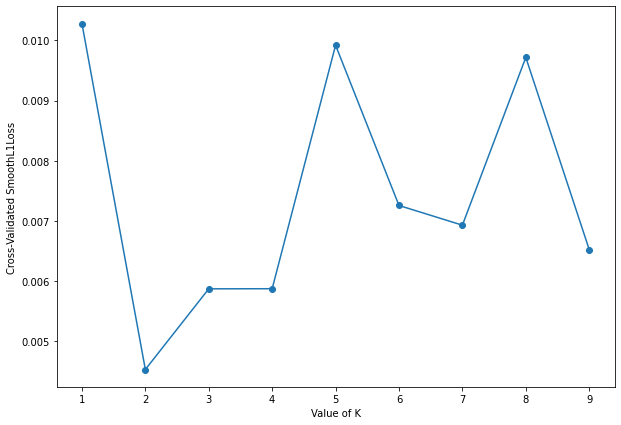

<Figure size 432x288 with 0 Axes>

In [31]:
myplot.k_fold_validation(n_groups, k_scores, save_name=path+"geo_k_fold.png")

### Train model

In [32]:
x_train, y_train = df_train[geo_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [33]:
model_geo, train_hist_geo, _ = train_model(model_geo, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            save_name=path+"geo_model.pth")

Epoch 0 train loss: 0.006116178818047047
Epoch 10 train loss: 0.007166131865233183
Epoch 20 train loss: 0.0061574289575219154
Epoch 30 train loss: 0.006103107240051031
Epoch 40 train loss: 0.006085748318582773


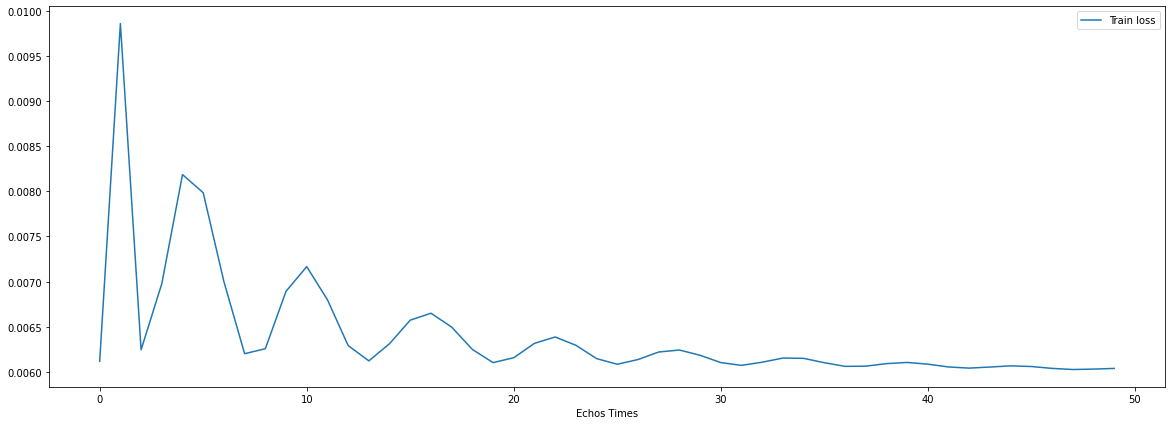

In [34]:
myplot.model_loss({"Train loss":train_hist_geo}, save_name=path+"geo_loss.png")

## Semigeo Features

In [36]:
model_semigeo = MLP_Regression(
  input_size=50,
  hidden_size=1000
)

In [37]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=semigeo_cols, target=target, n_groups=n_groups, model=model_semigeo, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.04084394499659538 test loss: 0.03247469291090965
Epoch 10 train loss: 0.013983859680593014 test loss: 0.015399658121168613
Epoch 20 train loss: 0.012195305898785591 test loss: 0.014804739505052567
Epoch 30 train loss: 0.011499989777803421 test loss: 0.013574696145951748
Epoch 40 train loss: 0.010930747725069523 test loss: 0.013118415139615536
Epoch 49 train loss: 0.010746035724878311 test loss: 0.013078367337584496
Epoch 0 train loss: 0.011562291532754898 test loss: 0.005702213384211063
Epoch 10 train loss: 0.013168483972549438 test loss: 0.007488335948437452
Epoch 20 train loss: 0.011761989444494247 test loss: 0.006351911462843418
Epoch 30 train loss: 0.011257441714406013 test loss: 0.0057630110532045364
Epoch 40 train loss: 0.011147421784698963 test loss: 0.00563950976356864
Epoch 49 train loss: 0.01106145791709423 test loss: 0.0056333765387535095
Epoch 0 train loss: 0.010921278037130833 test loss: 0.006617473904043436
Epoch 10 train loss: 0.010882371105253696 t

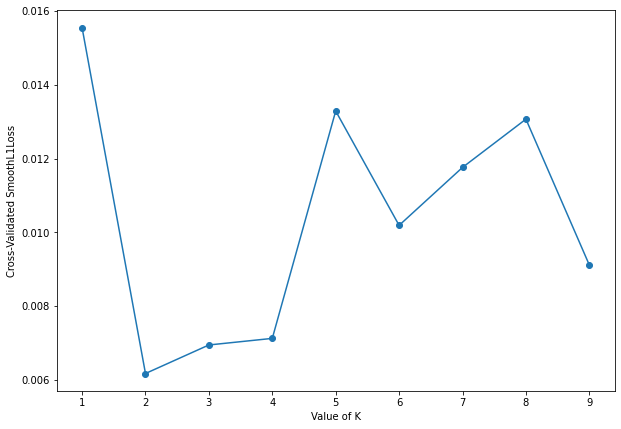

<Figure size 432x288 with 0 Axes>

In [38]:
myplot.k_fold_validation(n_groups, k_scores, save_name=path+"semigeo_k_fold.png")

### Train model

In [39]:
x_train, y_train = df_train[semigeo_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [40]:
model_semigeo, train_hist_semigeo, _ = train_model(model_semigeo, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            save_name=path+"semigeo_model.pth")

Epoch 0 train loss: 0.008911375887691975
Epoch 10 train loss: 0.010191935114562511
Epoch 20 train loss: 0.009090392850339413
Epoch 30 train loss: 0.008798145689070225
Epoch 40 train loss: 0.00874717440456152


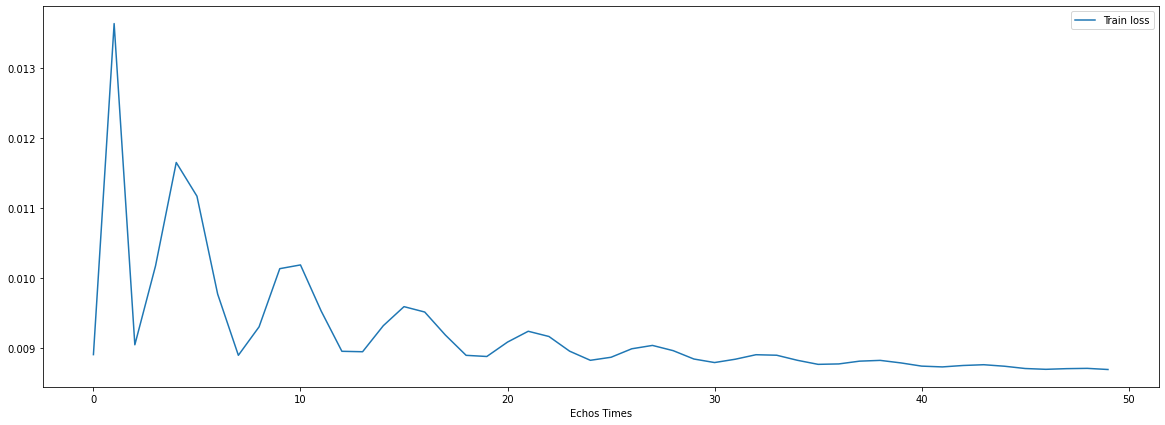

In [41]:
myplot.model_loss({"Train loss":train_hist_semigeo}, save_name=path+"semigeo_loss.png")